In [2]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import disrnn
import rnn_utils
from rnn_utils import DatasetRNN
import subject_data
from subject_data import SubjectData
from tueplots import bundles, figsizes, cycler
from tueplots.constants import markers
from tueplots.constants.color import rgb, palettes

plt.rcParams.update({"figure.dpi": 150})

# Load Data

In [3]:
data_dir = '..\data\data_for_Meike.mat'
matDf = loadmat(data_dir)['data']
df = pd.DataFrame(np.squeeze(np.array(matDf.tolist())).T, columns=matDf.dtype.names).drop(columns=['label','Spcorrect1', 'Spcorrect2', 'Snoise']).sort_values(by=['subject', 'trial'])

df['Sconfidence'] = df.groupby(['subject', 'block'])['Sreport'].transform(lambda x: np.where(x >= np.mean(x), 1, 0))
df['theta'] = np.absolute(df['dtheta'])


df ['theta_rescaled'] = 0

for subject in df['subject'].unique():
    df.loc[df['subject'] == subject, 'theta_rescaled'] = pd.qcut(
        df.loc[df['subject'] == subject, 'theta'], 
                4, 
                labels=[1, 2, 3, 4]
            ).astype(int)
    

# split by partner type
df_1 = df[df['type'] == 1]
df_2 = df[df['type'] == 2]

# one df for each block
for i in range(1,5):
        exec(f'df_1_{i} = df_1[df_1["block"] == {i}]')
        exec(f'df_2_{i} = df_2[df_2["block"] == {i}]')

Text(0.5, 1.0, 'Block 4')

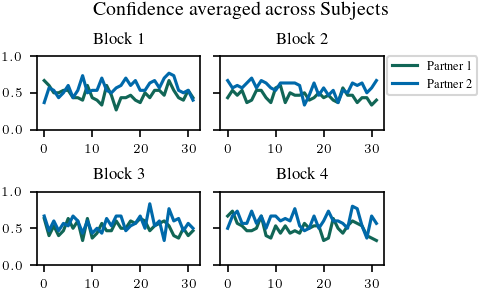

In [4]:
# Plot the data
plt.rcParams.update(
    bundles.icml2022(
        column="full",
        nrows=2,
        ncols=2,
        usetex=True,
    )
)
plt.rcParams.update(figsizes.icml2022_half(nrows=2, ncols=2))

fig, axs = plt.subplots(2,2, sharey = True)
fig.suptitle('Confidence averaged across Subjects')

### BLOCK 1 ###
xs_1_1 = np.zeros((32, 30))
xs_2_1 = np.zeros((32, 30))
for s, subject in enumerate(np.sort(df['subject'].unique())):
    xs_1_1[:,s] = df_1_1[df_1_1['subject'] == subject]['Sconfidence'].values
    xs_2_1[:,s] = df_2_1[df_2_1['subject'] == subject]['Sconfidence'].values
axs[0,0].plot(xs_1_1.mean(axis=1), color=rgb.mps_green, label='Partner 1')
axs[0,0].plot(xs_2_1.mean(axis=1), color=rgb.tue_blue, label='Partner 2')
axs[0,0].set_title('Block 1')
axs[0,0].set_ylim([0,1])

### BLOCK 2 ###
xs_1_2 = np.zeros((32, 30))
xs_2_2 = np.zeros((32, 30))
for s, subject in enumerate(np.sort(df['subject'].unique())):
    xs_1_2[:,s] = df_1_2[df_1_2['subject'] == subject]['Sconfidence'].values
    xs_2_2[:,s] = df_2_2[df_2_2['subject'] == subject]['Sconfidence'].values
axs[0,1].plot(xs_1_2.mean(axis=1), color=rgb.mps_green, label='Partner 1')
axs[0,1].plot(xs_2_2.mean(axis=1), color=rgb.tue_blue, label='Partner 2')
axs[0,1].set_title('Block 2')
axs[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### BLOCK 3 ###
xs_1_3 = np.zeros((32, 30))
xs_2_3 = np.zeros((32, 30))
for s, subject in enumerate(np.sort(df['subject'].unique())):
    xs_1_3[:,s] = df_1_3[df_1_3['subject'] == subject]['Sconfidence'].values
    xs_2_3[:,s] = df_2_3[df_2_3['subject'] == subject]['Sconfidence'].values
axs[1,0].plot(xs_1_3.mean(axis=1), color=rgb.mps_green, label='Partner 1')
axs[1,0].plot(xs_2_3.mean(axis=1), color=rgb.tue_blue, label='Partner 2')
axs[1,0].set_title('Block 3')

### BLOCK 4 ###
xs_1_4 = np.zeros((32, 30))
xs_2_4 = np.zeros((32, 30))
for s, subject in enumerate(np.sort(df['subject'].unique())):
    xs_1_4[:,s] = df_1_4[df_1_4['subject'] == subject]['Sconfidence'].values
    xs_2_4[:,s] = df_2_4[df_2_4['subject'] == subject]['Sconfidence'].values
axs[1,1].plot(xs_1_4.mean(axis=1), color=rgb.mps_green, label='type 1')
axs[1,1].plot(xs_2_4.mean(axis=1), color=rgb.tue_blue, label='type 2')
axs[1,1].set_title('Block 4')





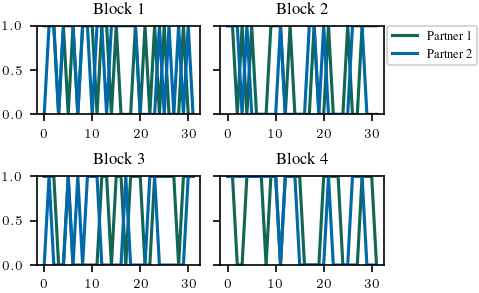

In [5]:
# plot choice distribution of single subject
fig, ax = plt.subplots(2,2, sharey= True)
subject = 3
ax[0,0].plot(xs_1_1[:,subject], color=rgb.mps_green, label='Partner 1')
ax[0,0].plot(xs_2_1[:,subject], color=rgb.tue_blue, label='Partner 2')
ax[0,0].set_title('Block 1')
ax[0,0].set_ylim([0,1])


ax[0,1].plot(xs_1_2[:,subject], color=rgb.mps_green, label='Partner 1')
ax[0,1].plot(xs_2_2[:,subject], color=rgb.tue_blue, label='Partner 2')
ax[0,1].set_title('Block 2')
ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

ax[1,0].plot(xs_1_3[:,subject], color=rgb.mps_green, label='Partner 1')
ax[1,0].plot(xs_2_3[:,subject], color=rgb.tue_blue, label='Partner 2')
ax[1,0].set_title('Block 3')

ax[1,1].plot(xs_1_4[:,subject], color=rgb.mps_green, label='Partner 1')
ax[1,1].plot(xs_2_4[:,subject], color=rgb.tue_blue, label='Partner 2')
ax[1,1].set_title('Block 4')

plt.show()




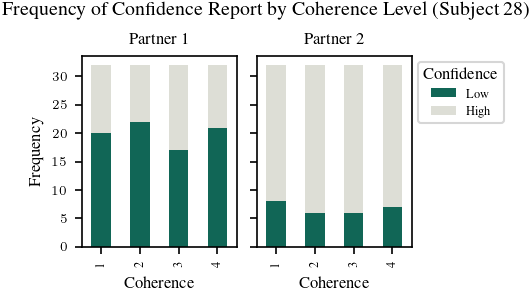

In [90]:
# Filter for a specific subject
subject = 28
subset_df_1 = df_1[df_1['subject'] == subject]
subset_df_2 = df_2[df_2['subject'] == subject]

# Calculate frequencies of each combination of theta_rescaled and Sreport
counts_1 = subset_df_1.groupby(['theta_rescaled', 'Sconfidence']).size().unstack(fill_value=0)
counts_2 = subset_df_2.groupby(['theta_rescaled', 'Sconfidence']).size().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots(1,2, sharey=True)
counts_1.plot(kind='bar', stacked=True, ax=ax[0], color=[rgb.mps_green, rgb.mps_gray])
counts_2.plot(kind='bar', stacked=True, ax=ax[1], color=[rgb.mps_green, rgb.mps_gray])

# Customizing plot
ax[0].set_xlabel('Coherence')
ax[1].set_xlabel('Coherence')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Partner 1')
ax[1].set_title('Partner 2')
ax[1].legend(title='Confidence', bbox_to_anchor=(1, 1), loc='upper left', labels=['Low', 'High'])
ax[0].get_legend().remove()
plt.suptitle(f'Frequency of Confidence Report by Coherence Level (Subject {subject})')

plt.show()